In [1]:
# %pip install snscrape
# nltk.download('stopwords')
# %pip install vaderSentiment
# %pip install community
# %pip install python-louvain
# %pip install apyori
# %pip install func_timeout
# %pip install wordcloud

In [2]:
from datetime import datetime, timedelta
import csv
import snscrape.modules.twitter as sntwitter
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.graph_objs as go
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")
import numpy as np
import community
from collections import Counter
from apyori import apriori
import time
from func_timeout import func_timeout, FunctionTimedOut
from wordcloud import WordCloud

# <font color = 'red'>Define search criteria</font>

In [3]:
keyword = '#stateoftheunionaddress'

max_tweets = 5000

In [4]:
dt = datetime.now().strftime("%Y-%m-%d_%H%M")
file_name = 'twitter_data/twitter_{}_{}_{}.csv'.format(keyword, max_tweets, dt)

with open(file_name, 'a', newline='', encoding='utf8') as csvFile:
    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(['id','date','tweet']) 
    
    n = 1
    
    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(keyword).get_items()) :
        
        # run line below to only download tweets in English
        # if tweet.lang == 'en':
            
            print(n)
            n += 1
            
            if i > max_tweets :
                break   
                
            formatted_date_time = tweet.date.strftime("%Y-%m-%d %H:%M:%S")
            csvWriter.writerow([tweet.id, formatted_date_time, tweet.rawContent])

csvFile.close()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [5]:
filename = 'twitter_data/twitter_{}_{}_{}.csv'.format(keyword, max_tweets, dt)

# filename = 'twitter_data/gggggggggggg.csv'

In [6]:
def normalise_text(text, column_name):
    # Initialize lemmatizer and list of stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    # Add additional stopwords
    stopword_list = ['http', 'amp', 'my_stopword3']
    stop_words.update(stopword_list)
    # Remove punctuation and tokenize words
    text = [word for word in word_tokenize(text) if word.isalnum()]
    
    # Extract the POS tag of each word
    text = pos_tag(text)
    
    # Lemmatize words and convert verbs to infinitive form
    text = [lemmatizer.lemmatize(word, 'v') if tag in ['VB','VBD','VBG','VBN','VBP','VBZ'] else lemmatizer.lemmatize(word) for word, tag in text]
    
    # Lemmatize words
    text = [lemmatizer.lemmatize(word) for word in text]
    
    # Extract only nouns, verbs, adjectives, adverbs
    text = [word for word, tag in pos_tag(text) if tag in ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ','JJ','JJR','JJS','RB','RBR','RBS']]
    
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    
    # Join tokenized, tidied words
    text = ' '.join(text)
    
    return text
    

In [7]:
# load data from csv file
tweets = pd.read_csv(filename)
tweets.columns = ['id', 'datetime', 'text']
tweets['datetime'] = pd.to_datetime(tweets['datetime'])


# Create a new column 'lower' and populate it with the lowercase version of the text in the 'tweet' column
tweets['lower'] = tweets['text'].str.lower()

# Create new columns suitable for network analysis
# Create a new column 'hashtags' and populate it with all the words starting with '#' in the 'lower' column
tweets['hashtags'] = tweets['lower'].apply(lambda x: " ".join(re.findall(r'#\w+', x)))
tweets['hashtags_list'] = tweets['hashtags'].apply(lambda x: x.split())
tweets.drop(labels='hashtags', axis=1, inplace=True)

# Create a new column 'mentions' and populate it with all the words starting with '@' in the 'lower' column
tweets['mentions'] = tweets['lower'].apply(lambda x: " ".join(re.findall(r'@\w+', x)))
tweets['mentions_list'] = tweets['mentions'].apply(lambda x: x.split())
tweets.drop(labels='mentions', axis=1, inplace=True)

# Create a new column 'tidied'
tweets['tidied'] = tweets['lower'].apply(lambda x: normalise_text(x, 'lower'))
tweets['tidied_list'] = tweets['tidied'].apply(lambda x: x.split())
tweets.drop(labels='tidied', axis=1, inplace=True)

# Create a new column 'tickers' and populate it with all the words starting with '$' and followed by 3-4 letters in the 'lower' column
tweets['tickers'] = tweets['lower'].apply(lambda x: " ".join(re.findall(r'\$[a-zA-Z]{3,4}', x)))
tweets['tickers_list'] = tweets['tickers'].apply(lambda x: x.split())
tweets.drop(labels='tickers', axis=1, inplace=True)

In [8]:
def sentiment_score(column):
    analyzer = SentimentIntensityAnalyzer()
    scores = []
    for sentence in column:
        score = analyzer.polarity_scores(sentence)['compound']
        scores.append(score)
    return scores

tweets['sentiment_score'] = sentiment_score(tweets['text'])

def label_sentiment(row):
    score = row["sentiment_score"]
    if score >= 0.05:
        return "positive"
    elif score > -0.05 and score < 0.05:
        return "neutral"
    else:
        return "negative"

tweets['sentiment'] = tweets.apply(lambda row: label_sentiment(row), axis=1)


In [9]:
print("Total tweets:   ", len(tweets))
print("Start datetime (UTC): ", tweets.datetime.min())
print("End datetime (UTC):   ", tweets.datetime.max())

Total tweets:    5001
Start datetime (UTC):  2023-02-08 03:15:18
End datetime (UTC):    2023-02-08 05:12:47


# <font color = 'red'>Filter data by date</font>

In [10]:
TIME_DELTA = 2

In [11]:
if TIME_DELTA != 0:
    yesterday_datetime = datetime.utcnow() - timedelta(TIME_DELTA)
    tweets = tweets[tweets['datetime'] >= yesterday_datetime]
    print("Starting datetime: ", tweets['datetime'].min())
    print("Total tweets:      ", len(tweets))
else:
    pass

Starting datetime:  2023-02-08 03:15:18
Total tweets:       5001


### Duplicate tweets

In [12]:
print("Total duplicate tweets: ", tweets.duplicated(subset = 'text').sum())

Total duplicate tweets:  68


In [13]:
duplicates = tweets.groupby('text').size().reset_index(name='frequency')
duplicates = duplicates[duplicates['frequency'] > 1].sort_values(by='frequency', ascending=False)

duplicates

text  frequency
277                             #StateOfTheUnionAddress         52
270            #StateOfTheUnion #StateOfTheUnionAddress          4
443                   #StateOfTheUnionAddress #sotu2023          4
1124  @RepMTG Your white Balloon photo op is yet aga...          3
1149  @RepTenney If you follow Claudia Tenney tonigh...          3
2601  If you follow Claudia Tenney tonight you will ...          3
59    "We must be the nation we have always been at ...          2
220   #SOTU #SOTU23 #StateOfTheUnionAddress #Stateof...          2
695   #Woofwoof just reminded me not to feed any mor...          2
3905  The President #SOTU President Biden #StateOfTh...          2
4759  too bad the POS former president didn’t have t...          2

# <font color = 'red'>Print entire duplicated tweet</font>

In [14]:
pd.options.display.max_colwidth = None

index_num = 1308

if index_num in duplicates.index:
    display(duplicates[duplicates.index == index_num])

In [15]:
tweets.drop_duplicates(subset='text', inplace=True)
print("Total tweets without duplicates: ", len(tweets))

Total tweets without duplicates:  4933


In [16]:
print("Length of dataframe minus duplicates: ", len(tweets))

Length of dataframe minus duplicates:  4933


# <font color = 'red'>Drop rows containing phrase</font>

In [17]:
REMOVE_FIRST  = "iiiiiiiiiiiii"

REMOVE_SECOND = "iiiiiiiiiiiii"

REMOVE_THIRD  = "iiiiiiiiiiiii"

In [18]:
remove_SPAM = pd.DataFrame()
remove_SPAM = tweets[
    (tweets['text'].str.contains(REMOVE_FIRST)) | 
    (tweets['text'].str.contains(REMOVE_SECOND)) |
    (tweets['text'].str.contains(REMOVE_THIRD))
]
remove_SPAM_index = remove_SPAM.index.tolist()
tweets.drop(remove_SPAM_index, inplace = True)
tweets.reset_index()
print("Total tidied tweets: ", len(tweets))

Total tidied tweets:  4933


### User defined functions

In [19]:
def create_network_plot(nodes_list, threshold_value, frac_value, xval, yval):
    def create_undirected_graph(nodes_list):
        G = nx.Graph() #create an empty undirected graph
        for nodes in nodes_list:
            for i in range(len(nodes)):
                for j in range(i+1, len(nodes)):
                    G.add_edge(nodes[i], nodes[j])
        return G

    G = create_undirected_graph(nodes_list.sample(frac=frac_value))
    
    plt.figure(figsize=(xval,yval))

    degree_centrality = nx.degree_centrality(G)

    threshold = np.percentile(list(degree_centrality.values()), threshold_value)

    for node in list(G.nodes()):
        if degree_centrality[node] < threshold:
            G.remove_node(node)

    new_node_sizes = [degree_centrality[node]*50000 for node in G.nodes() if degree_centrality[node]>=threshold]

    partition = community.best_partition(G, resolution=1)
    colors = [partition[node] for node in G.nodes()]
    
    # Create a dictionary where the keys are the community labels and the values are the nodes in that community
    community_dict = {}
    for node, label in partition.items():
        if label not in community_dict:
            community_dict[label] = []
        community_dict[label].append(node)
    
    # Create a dataframe where each column represents a community
    df = pd.DataFrame(columns=list(community_dict.keys()))    
    
    # For each community, calculate the 20 most frequently used nodes and add them to the dataframe
    for label in community_dict:
        nodes_counts = Counter(community_dict[label])
        top_nodes = nodes_counts.most_common(20)
        top_nodes = [x[0] for x in top_nodes]
        top_nodes = top_nodes + [""]*(20-len(top_nodes))  # Add empty strings to make the list length 20
        df[label] = top_nodes
        
    df.to_csv(f'{nodes_list.name}_df.csv')


    nx.draw_networkx(G,
                     node_size=new_node_sizes,
                     node_color=colors,
                     edge_color='#d3d3d3',
                     font_color='black',
                     font_weight="heavy",
                     font_size=10,
                     labels={node:node for node in G.nodes()},
                     cmap='rainbow')
    
    plt.grid()
    plt.show()
    display(df[df.nunique(1)>1])

    
    
def plot_most_common_words(df, column, n):
    words = df[column].tolist() # convert the column to a list
    words = [word for sublist in words for word in sublist] # flatten the list of lists
    word_counts = Counter(words) # count the occurrences of each word
    most_common_words = word_counts.most_common(n) # get the n most common words
    
    # create the barplot
    plt.figure(figsize=(18, 8)) 
    plt.bar(range(len(most_common_words)), [count for word, count in most_common_words], align='center', color='crimson')
    plt.xticks(range(len(most_common_words)), [word for word, count in most_common_words], rotation=90, fontsize=24)
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.title('Most Common Words')
    plt.figure(figsize=(25, 10)) 
    plt.show()

    
    
def line_plot(df, y_cols, TITLE):
    data = []
    for col in y_cols:
        trace = go.Scatter(x=df.index, y=df[col], name=col)
        data.append(trace)
    layout = go.Layout(title=TITLE, xaxis=dict(title='', showticklabels=False, range=[-10, df.index.max()]), yaxis=dict(title='frequency'),
                      showlegend=True, 
                      margin=go.layout.Margin(l=50,r=50,b=50,t=50),
                      width=800,
                      height=400)
    fig = go.Figure(data=data, layout=layout)
    fig.show()

    
    
def find_min_support(data):
    start_time = time.time()
    temp_list = []
    
    running_time = 5
    
    def while_loop():
        
        min_support = 1
        lowest_support = 1
        start_time = time.time()
        
        while True:
            
            association_rules = apriori(data, min_support=lowest_support, min_confidence=0.1, min_lift=1, min_length=2)
            association_results = list(association_rules)
            
            if lowest_support > 0.01:
                lowest_support -= 0.01
            else:
                lowest_support -= 0.001
                
            if lowest_support <= 0:
                lowest_support = 0.001
            temp_list.append(lowest_support)
            if time.time() - start_time > 0.5:
                break
    
    try:
        func_timeout(10, while_loop)
    except FunctionTimedOut:
        pass
    
    SUPPORT = temp_list[-3]
    print("Support: ", round(SUPPORT, 4))
    return SUPPORT



def create_apriori_df(association_results):
    apriori_df = pd.DataFrame(columns=('Items','Antecedent','Consequent','Support','Confidence','Lift'))
    Support =[]
    Confidence = []
    Lift = []
    Items = []
    Antecedent = []
    Consequent=[]
    for RelationRecord in association_results:
        for ordered_stat in RelationRecord.ordered_statistics:
            Support.append(RelationRecord.support)
            Items.append(RelationRecord.items)
            Antecedent.append(ordered_stat.items_base)
            Consequent.append(ordered_stat.items_add)
            Confidence.append(ordered_stat.confidence)
            Lift.append(ordered_stat.lift)
    apriori_df['Items'] = Items                          
    apriori_df['Antecedent'] = Antecedent
    apriori_df['Consequent'] = Consequent
    apriori_df['Support'] = Support
    apriori_df['Confidence'] = Confidence
    apriori_df['Lift']= Lift
    return apriori_df.sort_values(by ='Support', ascending = False, inplace = False)



def subset_list(hashtags_list, specific_hashtag):
    subset = []
    for hashtags in hashtags_list:
        if specific_hashtag in hashtags:
            subset.append(hashtags)
    return subset



def create_wordcloud(df, column, max_words):
    # Join the rows of the specified column into a single string
    text = " ".join(df[column].apply(lambda x: " ".join(x)))
    
    # Generate a word cloud from the text
    wordcloud = WordCloud(max_words=max_words,
                          background_color='white',
                          colormap='viridis'
                         ).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 14))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# <font color = 'red'>Hashtag analysis</font>

In [20]:
# Use pandas' Series.explode() method to convert the 'hashtags_list' column into multiple rows
hashtags = tweets['hashtags_list'].explode()

# Count the frequency of each unique hashtag using pandas' Series.value_counts() method
hashtag_frequency = hashtags.value_counts()

# Convert the frequency counts into a dataframe using pandas' DataFrame constructor
hashtag_frequency_df = pd.DataFrame({'hashtag': hashtag_frequency.index, 'frequency': hashtag_frequency.values})

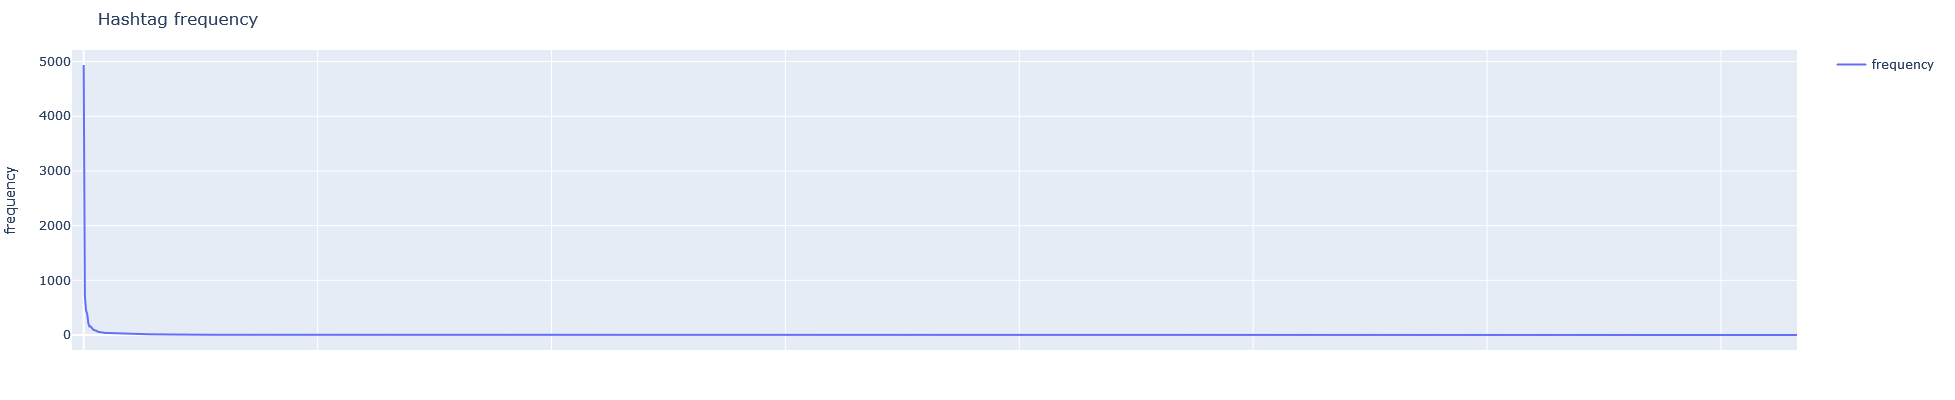

In [21]:
line_plot(hashtag_frequency_df, ['frequency'], "Hashtag frequency")

In [22]:
hashtag_frequency_df

top_hashtags_styler = hashtag_frequency_df.style.set_properties(**{'text-align': 'left'})
top_hashtags_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

### Hashtag network analysis

In [62]:
create_network_plot(tweets['hashtags_list'], 80, 1, 18, 18)

4                      1                      0   \
0   #stateoftheunionaddress                  #sotu                 #biden   
1               #ワイのloveゲーム   #stateoftheunion2023                 #china   
2                   #wwenxt              #sotu2023     #chinesespyballoon   
3                    #gojoe           #tyrenichols            #huckabeast   
4         #letsfinishthejob  #marjorietaylorgreene            #republican   
5             #kamalaharris                   #mtg                  #news   
6                   #maddow       #stateoftheunion          #georgesantos   
7              #socialmedia              #congress                 #trump   
8                     #woke         #kevinmccarthy                 #state   
9              #sanremo2023                   #gop          #breakingnews   
10               #jillbiden                   #usa              #breaking   
11                #cruzeiro             #democrats  #democratshateamerica   
12                   #フォロー中           #republicans             #factcheck   
13                    #logo        #presidentbiden            #mittromney   
14              #logodesign           #gopresponse              #trending   
15              #modernlogo   #republicanclownshow    #majorietaylorgreen   
16                 #applogo               #economy                #santos   
17             #application                   #gun                 #photo   
18                 #appicon               #america               #cbsnews   
19           #douglasemhoff          #2ndamendment              #exchange   

                       5                          6   \
0                 #russia                       #fjb   
1                #ukraine                      #liar   
2               #joebiden                 #bidenlies   
3                  #covid              #bordercrisis   
4              #inflation                 #trump2024   
5              #americans                    #kamala   
6     #bidensbordercrisis                       #wtf   
7               #gasprice   #bidenworstpresidentever   
8   #afghanistanwithdrawl              #bidenflation   
9        #vaccinemandates      #bidendestroysamerica   
10               #vaccine         #bidenbordercrisis   
11               #taliban             #letsgobrandon   
12                 #putin               #americanoil   
13       #emptyshelvesjoe              #americafirst   
14           #babyformula  #joebidenisnotmypresident   
15   #russianukrainianwar                       #lgb   
16           #factsmatter         #bidencrimefamilly   
17                               #corruptpolititians   
18                                     #fuckjoebiden   
19                         #bidenclassifieddocuments   

                                7                          8   \
0                #stateofconfusion                #loveisland   
1                           #unity                     #rhonj   
2                 #stateofdisunion               #turkeyquake   
3   #humanitarianindustrialcomplex                 #bbtitians   
4                      #waronwomen             #prayforturkey   
5                  #followthemoney                     #funny   
6                       #womanface          #turkeyearthquake   
7         #genderindustrialcomplex             #hogwartlegacy   
8            #syntheticsexidentity                    #lebron   
9                         #esgscam                    #kareem   
10                            #esg               #lebronjames   
11                            #sbf                   #grammys   
12                          #gates                    #turkey   
13                                                       #nba   
14                                                       #fyp   
15                                                  #lakeshow   
16                                                   #turquia   
17                                                #helpturke

### Hashtag apriori analysis

In [24]:
# # Convert the list of hashtags into a list of transactions

hashtags_list = [hashtags for hashtags in tweets.hashtags_list]

In [25]:
# association_rules = apriori(hashtags_list, min_support=find_min_support(hashtags_list), min_confidence=0.1, min_lift=1, min_length=2)
# association_results = list(association_rules)
# print("Length association results:", len(association_results))

In [26]:
# pd.options.display.max_rows = None
# 
# create_apriori_df(association_results)

### Unique item combinations

In [27]:
# pd.options.display.max_rows = None
# 
# df_unique_hashtag_items = (create_apriori_df(association_results)
#                            .drop_duplicates(subset=['Items'], keep='first')
#                            .sort_values(by='Support', ascending=False)
#                            .loc[:, ['Items', 'Support']])
# 
# df_unique_hashtag_items.head(100)

### Subset hashtag data on specific hashtag

In [28]:
SUBSET_HASHTAG = "#analytics"

hashtag_subset = subset_list(hashtags_list, SUBSET_HASHTAG)

In [29]:
association_rules = apriori(hashtag_subset, min_support=find_min_support(hashtag_subset), min_confidence=0.1, min_lift=1, min_length=2, max_rules=100)
hashtag_subset_association_results = list(association_rules)
print("Length association results:", len(hashtag_subset_association_results))

Support:  0.001
Length association results: 0


In [30]:
pd.options.display.max_rows = None

df_unique_hashtag_items = (create_apriori_df(hashtag_subset_association_results)
                           .drop_duplicates(subset=['Items'], keep='first')
                           .sort_values(by='Support', ascending=False)
                           .loc[:, ['Items', 'Support']])

df_unique_hashtag_items.head(100)

Empty DataFrame
Columns: [Items, Support]
Index: []

# <font color = 'red'>Mentions analysis</font>

In [31]:
# Use pandas' Series.explode() method to convert the 'mentions_list' column into multiple rows
mentions = tweets['mentions_list'].explode()

# Count the frequency of each unique mention using pandas' Series.value_counts() method
mentions_frequency = mentions.value_counts()

# Convert the frequency counts into a dataframe using pandas' DataFrame constructor
mentions_frequency_df = pd.DataFrame({'mentions': mentions_frequency.index, 'frequency': mentions_frequency.values})

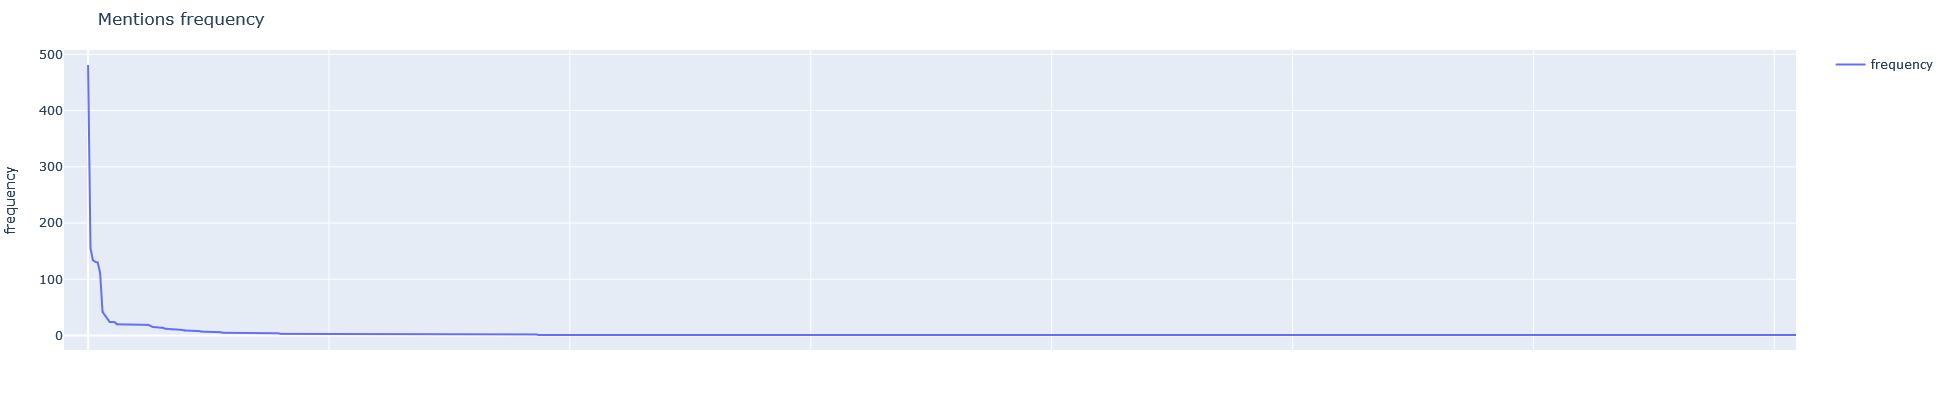

In [32]:
line_plot(mentions_frequency_df, ['frequency'], "Mentions frequency")

In [33]:
mentions_frequency_df

top_mentions_styler = mentions_frequency_df.style.set_properties(**{'text-align': 'left'})
top_mentions_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

### Mentions network analysis

In [66]:
create_network_plot(tweets['mentions_list'], 70, 1, 20, 20)

7                 1                 2                6  \
0             @potus   @symonedsanders         @joebiden             @gop   
1          @housegop    @michaelsteele        @kingjames             @cnn   
2         @senategop  @speakermccarthy    @berniesanders         @foxnews   
3           @thehill    @sarahhuckabee       @emilym0703         @cbsnews   
4               @dnc    @adamkinzinger     @phoneladyctt             @abc   
5        @senatedems           @repmtg        @riccigeri     @morning_joe   
6      @thedemocrats       @jim_jordan         @puff_mad        @redstate   
7    @jesseprimetime    @laurenboebert        @djtalways         @nytimes   
8      @kamalaharris  @rpsagainsttrump       @judiehall9     @greggutfeld   
9   @realdonaldtrump       @georgewill  @livrighteously1   @rolandsmartin   
10   @housedemocrats            @wsbtv    @danelletyler2  @blkstarnetwork   
11               @vp      @govchristie     @maryclare716   @reeciecolbert   
12       @mittromney       @teapainusa                      @1ericasavage   
13       @whitehouse      @meidastouch                      @africanacarr   
14        @gopleader           @joenbc                               @npr   
15   @mcconnellpress       @13wmaznews                     @speakerpelosi   
16       @sentedcruz              @gma                            @flotus   
17       @johncornyn        @mattgaetz                        @adamschiff   
18      @repjeffries           @zckbnt                           @nbcnews   
19    @colinallredtx  @michaeltomkiew1                               @wsj   

                   0                5                 8                 3  \
0             @msnbc         @clady62       @vanjones68     @marciabarrie   
1            @maddow           @brijh         @donlemon       @mary1kathy   
2          @lawrence      @glamor14kt      @wolfblitzer       @len_future   
3               @bbc       @tclarkusa      @danabashcnn       @feelsyoung   
4       @bbcbreaking   @ahoustonbelle  @victorblackwell    @badrobotlinda   
5          @bbcworld  @thesistahchick   @bakari_sellers    @progavalanche   
6       @bbcpolitics        @presssec       @jaketapper          @hategop   
7            @dwnews   @luvwinsresist   @andersoncooper        @eddsmitty   
8           @msnbcpr    @chrissysblog        @kasiehunt  @rogerledbette11   
9        @joyannreid   @liveonthechat       @smerconish    @midwest_voter   
10  @nicolledwallace  @jimmiemckinnon   @kaitlancollins    @resistamerica   
11        @arimelber   @justdoodirty3      @erinburnett     @darrinhall15   
12      @chrislhayes       @momof3pgh                          @doc_laing   
13       @alexwagner      @meghanpain                     @jackieresister   
14           @sruhle  @iamprettypetty                        @rubicon1313   
15          @peacock   @geraldorivera                      @xavierresists   
16                       @farrisflagg                       @3sidecarsplz   
17                        @we_thecrew                            @tpblue4   
18                                                                          
19                                                                          

                   4  
0           @chamath  
1             @jason  
2         @mayawiley  
3   @glennkirschner2  
4    @fatherhoodinst  
5      @nycdadsgroup  
6          @rokhanna  
7     @vincentcoyle1  
8        @rajeev_goi  
9       @ravikarkara  
10        @djfreshsa  
11         @vishhman  
12                    
13                    
14                    
15                    
16                    
17                    
18                    
19

### Mentions apriori analysis

In [35]:
# # Convert the list of mentions into a list of transactions

mentions_list = [mentions for mentions in tweets.mentions_list]

In [36]:
# association_rules = apriori(mentions_list, min_support=find_min_support(mentions_list), min_confidence=0.1, min_lift=1, min_length=2)
# association_results = list(association_rules)
# print("Length association results:", len(association_results))

In [37]:
# create_apriori_df(association_results)

### Unique item combinations

In [38]:
# pd.options.display.max_rows = None
# 
# df_unique_mention_items = (create_apriori_df(association_results)
#                            .drop_duplicates(subset=['Items'], keep='first')
#                            .sort_values(by='Support', ascending=False)
#                            .loc[:, ['Items', 'Support']])
# 
# df_unique_mention_items.head(100)

### Subset mention data on specific mention

In [39]:
SUBSET_MENTION = "@_mrszu"

mentions_subset = subset_list(mentions_list, SUBSET_MENTION)

In [40]:
mentions_association_rules = apriori(mentions_subset, min_support=find_min_support(mentions_subset), min_confidence=0.1, min_lift=1, min_length=2)
mention_subset_association_results = list(mentions_association_rules)
print("Length association results:", len(mention_subset_association_results))

Support:  0.001
Length association results: 0


In [41]:
pd.options.display.max_rows = None

df_unique_mention_items = (create_apriori_df(mention_subset_association_results)
                           .drop_duplicates(subset=['Items'], keep='first')
                           .sort_values(by='Support', ascending=False)
                           .loc[:, ['Items', 'Support']])

df_unique_mention_items.head(100)

Empty DataFrame
Columns: [Items, Support]
Index: []

# <font color = 'red'>Ticker analysis</font>

In [42]:
# Use pandas' Series.explode() method to convert the 'tickers' column into multiple rows
tickers = tweets['tickers_list'].explode()

# Count the frequency of each unique ticker using pandas' Series.value_counts() method
tickers_frequency = tickers.value_counts()

# Convert the frequency counts into a dataframe using pandas' DataFrame constructor
tickers_frequency_df = pd.DataFrame({'tickers': tickers_frequency.index, 'frequency': tickers_frequency.values})

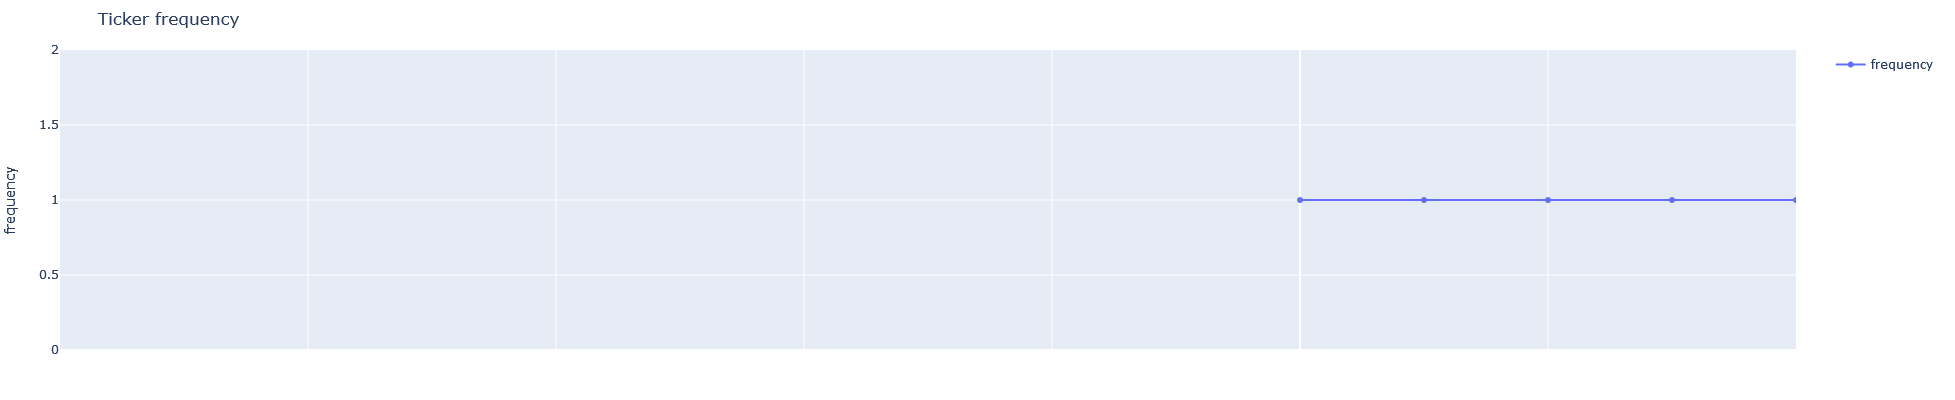

In [43]:
line_plot(tickers_frequency_df, ['frequency'], "Ticker frequency")

In [44]:
tickers_frequency_df

top_tickers_styler = tickers_frequency_df.style.set_properties(**{'text-align': 'left'})
top_tickers_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

### Ticker network analysis

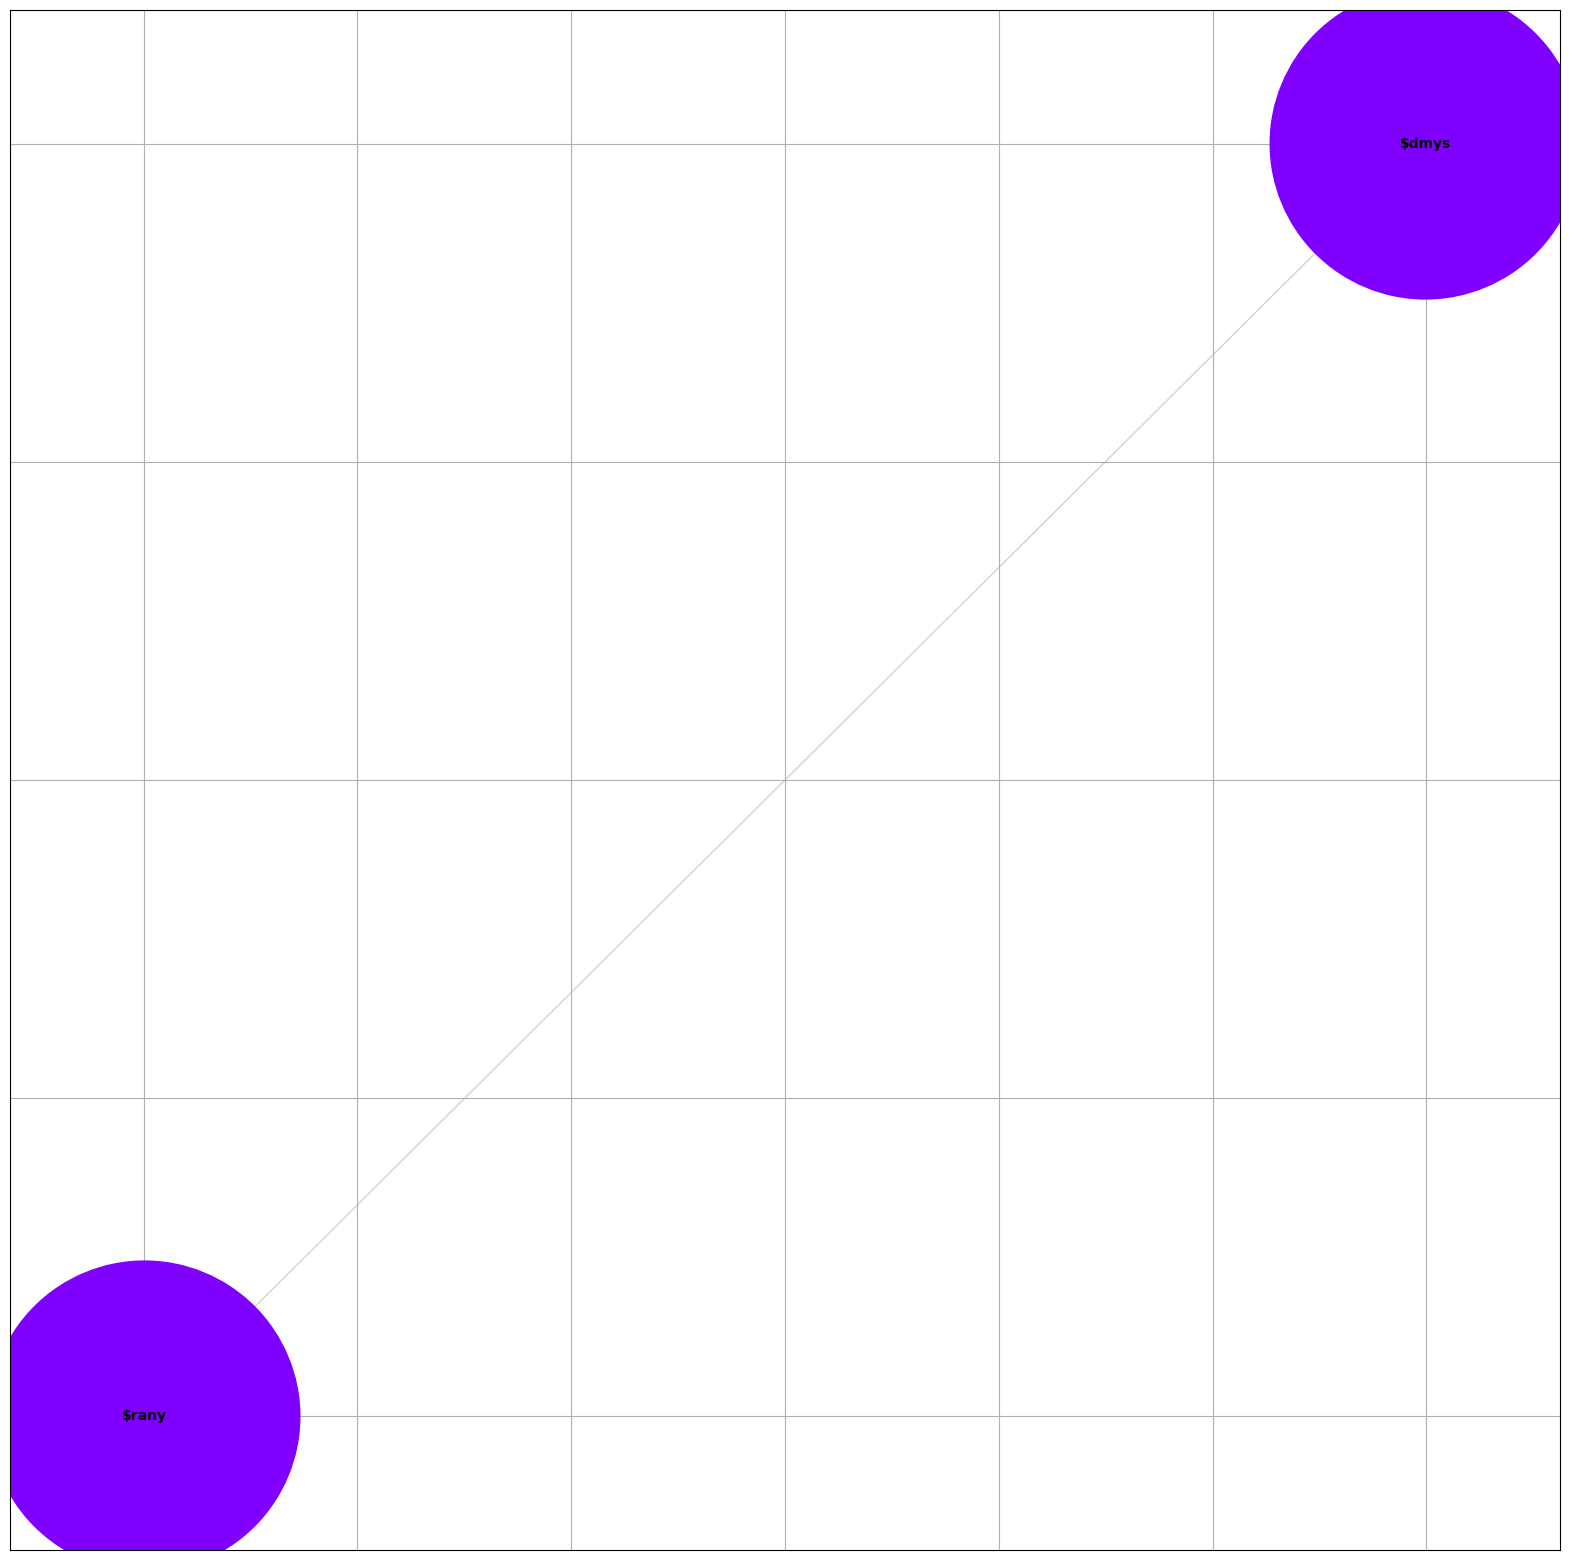

Empty DataFrame
Columns: [0]
Index: []

In [45]:
try:
    create_network_plot(tweets['tickers_list'], 0, 1, 20, 20)
except:
    pass

### Ticker apriori analysis

In [46]:
# # Convert the list of hashtags into a list of transactions

tickers_list = [tickers for tickers in tweets.tickers_list]

In [47]:
# association_rules = apriori(tickers_list, min_support=find_min_support(tickers_list), min_confidence=0.1, min_lift=1, min_length=2)
# association_results = list(association_rules)
# print("Length association results:", len(association_results))

In [48]:
# pd.options.display.max_rows = None
# 
# create_apriori_df(association_results)

### Unique item combinations

In [49]:
# pd.options.display.max_rows = None
# 
# df_unique_tickers_items = (create_apriori_df(association_results)
#                            .drop_duplicates(subset=['Items'], keep='first')
#                            .sort_values(by='Support', ascending=False)
#                            .loc[:, ['Items', 'Support']])
# 
# df_unique_tickers_items.head(100)

### Subset ticker data on specific ticker

In [50]:
SUBSET_TICKER = "$bac"

ticker_subset = subset_list(tickers_list, SUBSET_TICKER)

In [51]:
association_rules = apriori(ticker_subset, min_support=find_min_support(ticker_subset), min_confidence=0.1, min_lift=1, min_length=2)
ticker_subset_association_results = list(association_rules)
print("Length association results:", len(ticker_subset_association_results))

Support:  0.001
Length association results: 0


In [52]:
pd.options.display.max_rows = None

df_unique_ticker_items = (create_apriori_df(ticker_subset_association_results)
                           .drop_duplicates(subset=['Items'], keep='first')
                           .sort_values(by='Support', ascending=False)
                           .loc[:, ['Items', 'Support']])

df_unique_ticker_items.head(100)

Empty DataFrame
Columns: [Items, Support]
Index: []

# <font color = 'red'>Network analysis tidied tweets</font>

In [53]:
create_wordcloud(tweets, 'tidied_list', 50)

In [54]:
plot_most_common_words(tweets, 'tidied_list', 30)

<Figure size 2500x1000 with 0 Axes>

In [55]:
create_network_plot(tweets['tidied_list'], 70, 1, 20, 20)

0           1                       2             3         4  \
0            even       stand  stateoftheunionaddress         thing   believe   
1   kevinmccarthy       state                     get      response       min   
2             sad       union                exercise          dear      stop   
3      republican     address                   biden          lord   tedcruz   
4        actually   president                  create          full      able   
5            crap      repeat                sentence           lie     potus   
6           piece        make              bargaining       stutter    invest   
7       hypocrisy       equal                    easy          slur     money   
8           start       begin                  engage      sotu2023      drug   
9        mccarthy   otherwise             information        wonder     cross   
10           ever       claim                    sotu           god    border   
11        speaker         say                   bravo           bad    resort   
12           hell    violence               wonderful        simple       job   
13         greene      speech                 tonight       realize  military   
14      certainly   political                    time  conservative      much   
15          party        work              manipulate          talk      last   
16            sit  democratic              lyingbiden         nancy     month   
17           back    position                    rick        pelosi      sick   
18       moderate      course                    hook       husband      warm   
19            low        year                   crash  stateofunion     close   

          5                6                7  
0       day            worst            thank  
1    speaks           moment       everything  
2      clap         joebiden            mitch  
3      hour            whole        mcconnell  
4       eye              joe             cane  
5      take             meet             club  
6    single           easily           agenda  
7     tweet  godblessamerica        literally  
8      love           pretty           repubs  
9      feel              man         heckling  
10     good         imbecile             turn  
11      sir           sotu23           around  
12   anyone        bidenlies           commit  
13  nothing             weak         coverage  
14     well           friend       thoughtful  
15    still              ppl              tie  
16       go              til          younger  
17     real            laugh  professionalism  
18    never             main       joyannreid  
19      guy          history        arimelber

# <font color = 'red'>Display tweets on search criteria</font>

In [67]:
search_word = "sarah"

subset_search_word = ""

In [68]:
pd.options.display.max_rows = None

searched_comment = tweets[(tweets['lower'].str.contains(search_word)) & 
                          (tweets['lower'].str.contains(subset_search_word))] 

searched_comment = searched_comment[['text', 'sentiment_score', 'sentiment']]

print("Mean sentiment score: ", round(searched_comment.sentiment_score.mean(), 3))
print("Comments: ", len(searched_comment))

searched_comment

Mean sentiment score:  -0.025
Comments:  400


text  \
0                                   @EldoradoSan @RonWaxman @kadiagoba @SymoneDSanders @wsbtv @Jim_Jordan @GovChristie @SarahHuckabee @TeaPainUSA @MeidasTouch @JoeNBC @SpeakerMcCarthy @13wmaznews @GMA @RpsAgainstTrump @RepMTG is what my grandma called ‘po white trash’ #StateOfTheUnionAddress #MarjorieTaylorGreeneIsSoDumb   
22           @SpeakerMcCarthy @SarahHuckabee Sarah Suckabee is governor of a hillbilly state of 3million. \nHer speech was like a grade level précis from something that could have been uttered by Mussolini or Stalin. \nRacist, Fascist, Dictatorship \n#GOP \n#StateOfTheUnionAddress \n#SarahHuckabee \n#GOPSeditiousTraitors   
26                                                         @GeorgeWill @SymoneDSanders @wsbtv @Jim_Jordan @GovChristie @SarahHuckabee @TeaPainUSA @MeidasTouch @JoeNBC @SpeakerMcCarthy @13wmaznews @GMA @RpsAgainstTrump @RepMTG is what my grandma called ‘po white trash’ #StateOfTheUnionAddress #MarjorieTaylorGreeneIsSoDumb   
28                                                                             @nprpolitics Sarah Sanders referred to a “Conservative education plan”\nWhat we used to call “reeducation” when referring to the indoctrination of schoolkids in the Soviet Union, China, Viet Nam and North Korea. \n#SOTU #StateOfTheUnionAddress   
39                                                    @SpeakerMcCarthy @SymoneDSanders @wsbtv @Jim_Jordan @GovChristie @SarahHuckabee @TeaPainUSA @MeidasTouch @JoeNBC @SpeakerMcCarthy @13wmaznews @GMA @RpsAgainstTrump @RepMTG is what my grandma called ‘po white trash’ #StateOfTheUnionAddress #MarjorieTaylorGreeneIsSoDumb   
48                                                                                                                                                                              Love watching @jrpsaki @SymoneDSanders @MichaelSteele just go off on how ridiculous MTG &amp; sarah sanders were tonight.  #StateOfTheUnionAddress   
58              @ZckBnt @michaeltomkiew1 @MichaelSteele @hwinkler4real @SymoneDSanders @wsbtv @Jim_Jordan @GovChristie @SarahHuckabee @TeaPainUSA @MeidasTouch @JoeNBC @SpeakerMcCarthy @13wmaznews @GMA @RpsAgainstTrump @RepMTG is what my grandma called ‘po white trash’ #StateOfTheUnionAddress #MarjorieTaylorGreeneIsSoDumb   
77                                                                                                                                                                                                                   Some highlights from #SarahHuckabee brilliant response to the #StateOfTheUnionAddress https://t.co/YoQkxoTAda   
103                                                                                                                                                                                         Does anybody know what exactly Sarah Huckabee Sanders is talking about. It is all over the place. #GOPResponse #StateOfTheUnionAddress   
129              Mrs @SarahHuckabee former press secretary of Pre #DonaldTrump is now the youngest Governor of Arkansas.\nIn #republicanresponse to \nto the #StateOfTheUnionAddress she was critical of Pres #JoeBiden policies\n Governor Sarah and her Mom both are #cancer survivers. That was moving. https://t.co/2gPuAqjjAz   
154                                   Why did @SpeakerMcCarthy purposefully lie? Is he not a faithful father and a good christian? No wonder @elonmusk wanted him in power. I bet he bribed him\n\n#StateOfTheUnionAddress #ElonMuskTwitter #Biden #LiesToTheUnion #SarahHuckabee #SarahHuckabeeSanders\n\nhttps://t.co/xzszHGOeoM   
161                                         Lying .@SarahHuckabee prepared her rebuttal well before President Biden gave the #StateOfTheUnionAddress but didn’t have the common sense to modify her rebuttal comments based on what President Biden actually said. 🤭 Rookie mistake. 😂  #RepublicansAreTheProblem \n#GOPCultureWar   
174                                                                             

### Print entire tweet

In [69]:
index_num = 12

searched_text = searched_comment.text.loc[index_num] if index_num in searched_comment.index else None
display(searched_text)

None